*Author: Rahul Dev Sharma*

*Date: 25.08.23*

*Description: Constructed a quantum kernel for classical and quantum support vector machine to classify breast cancer patient data.*

*Email: [sci94tune@gmail.com](mailto:sci94tune@gmail.com)*

In [159]:
# Uncomment next line to install necessary packages
# !pip install qiskit qiskit-aer qiskit_machine_learning qiskit_algorithms --quiet

Firstly, load and preprocess the data. After that define/(select from qiskit circuit library) the ansatz and feature map(map classical features to quantum hilbert space). Then select an Optimizer and a Quantum Kernel Trainer instance with a kernel loss function(here SVCLoss). Then use this to fit the Kernel Matrix with training data, which is used in the SVC and QSVC models. Further improvements may include,

- Try running the algorithm using qiskit runtime. [Here](https://github.com/Qiskit-Partners/qiskit-runtime/blob/main/tutorials/qka.ipynb) is a sample implementation for running on real hardware.
- Benchmark different encoding techniques and optimizers.
- Try other algorithms (e.g. variational quantum classifier).
- Try changing number of features.

Here breast cancer datasets from `sklearn.datasets` is used.

In [1]:
from sklearn.preprocessing import OneHotEncoder
from pylab import cm
from sklearn import metrics
from sklearn.datasets import load_breast_cancer
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

Loading and inspecting the data

In [27]:
data = load_breast_cancer()
y = data.target
X = pd.DataFrame(data.data, columns = data.feature_names)
# Display the first few rows of the dataset
X.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
# Get basic information about the dataset
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

$Note$: A correlation matrix shows how pairs of variables are related, and it measures the strength and direction of these relationships. It's a valuable tool for identifying potential patterns and guiding further analysis. A strong correlation between two variables may or may not imply causation. Understanding the subject matter and domain-specific knowledge and context to draw meaningful conclusions from correlation findings is crucial.

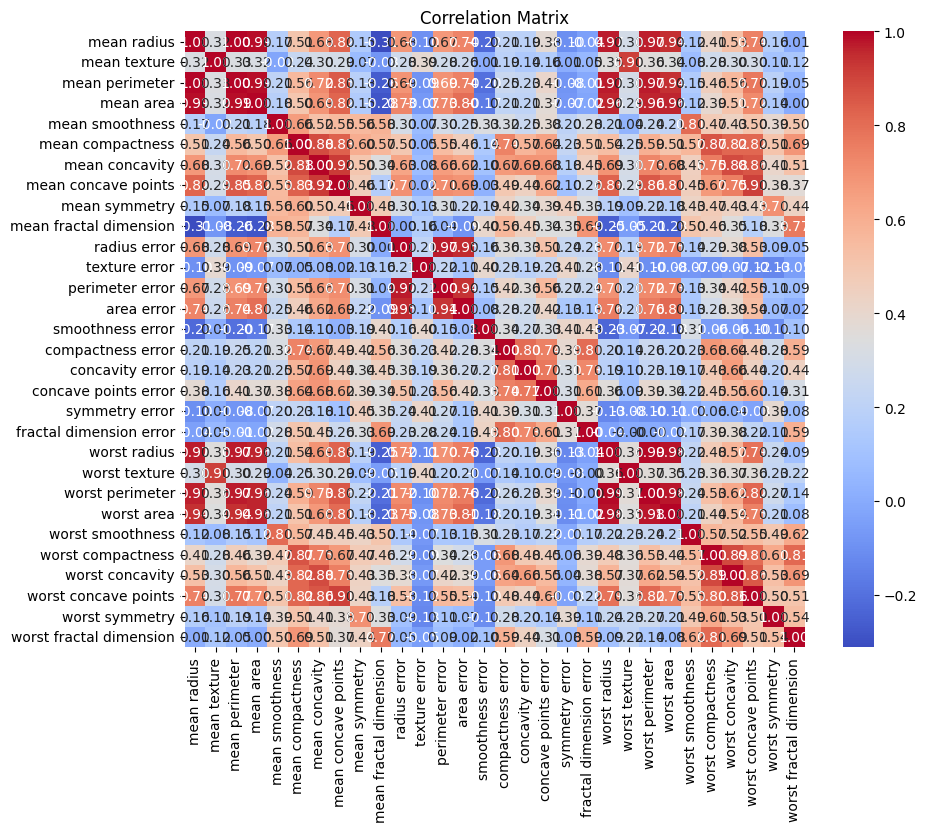

In [5]:
# 4. Correlation Analysis
# Compute and visualize the correlation matrix
correlation_matrix = X.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

Another way to observe correlation between features is to plot the them pair-wise. But it is not convenient for datasets with large number of features. The code is written in markdown below.

```
df = pd.DataFrame(data.data, columns=data.feature_names)
df["class"] = pd.Series(data.target)

sns.pairplot(df, hue="class", palette="tab10")
```

For the sake of comparing with QSVM and real device qubit limitation(free devices). I reduce to 7 or below 7 principle features.

In [40]:
from sklearn.decomposition import PCA
n = 3 #  Decided number of features
pca = PCA(n_components=n)  # Reduce to n principal components
X = pca.fit_transform(X)

$Note$: Scaling before splitting would introduce information from the test set into the scaling process, potentially leaking information and biasing your model's evaluation. We should first split the data then scale.

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=46)

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Now, Lets implement the quantum kernel

In [43]:
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.visualization import circuit_drawer
from qiskit_machine_learning.kernels import TrainableFidelityQuantumKernel
from qiskit_machine_learning.kernels.algorithms import QuantumKernelTrainer
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.datasets import ad_hoc_data


The following `QKTCallBack` class is used to keep track of the training loss.

In [2]:
class QKTCallback:
    """Callback wrapper class."""

    def __init__(self) -> None:
        self._data = [[] for i in range(5)]

    def callback(self, x0, x1=None, x2=None, x3=None, x4=None):
        """
        Args:
            x0: number of function evaluations
            x1: the parameters
            x2: the function value
            x3: the stepsize
            x4: whether the step was accepted
        """
        self._data[0].append(x0)
        self._data[1].append(x1)
        self._data[2].append(x2)
        self._data[3].append(x3)
        self._data[4].append(x4)

    def get_callback_data(self):
        return self._data

    def clear_callback_data(self):
        self._data = [[] for i in range(5)]

Implementing the featuremap and trainable paramtetric circuit.

In [77]:
from qiskit.circuit.library import ZZFeatureMap, EfficientSU2, TwoLocal, RealAmplitudes

# Initializing the trainable parameterized circuit
training_params = ParameterVector("θ", n)
fm0 = QuantumCircuit(n)
for i in range(n):
    fm0.ry(training_params[i], i)

# ansatz = TwoLocal(n, ['ry'], 'cz', 'full', reps=0, insert_barriers=True).decompose() # We will use parameters of this circuit to train 

# Use ZZFeatureMap to represent input data
fm1 = ZZFeatureMap(n, reps=1, entanglement='full')

# Create the feature map, composed of our two circuits
fm = fm0.compose(fm1)

print(circuit_drawer(fm))
print(f"Trainable parameters: {training_params,fm0.parameters}")

     ┌──────────┐┌───────────────────────────────┐
q_0: ┤ Ry(θ[0]) ├┤0                              ├
     ├──────────┤│                               │
q_1: ┤ Ry(θ[1]) ├┤1 ZZFeatureMap(x[0],x[1],x[2]) ├
     ├──────────┤│                               │
q_2: ┤ Ry(θ[2]) ├┤2                              ├
     └──────────┘└───────────────────────────────┘
Trainable parameters: (ParameterVector(name=θ, length=3), ParameterView([ParameterVectorElement(θ[0]), ParameterVectorElement(θ[1]), ParameterVectorElement(θ[2])]))


To train the quantum kernel, we will use an instance of TrainableFidelityQuantumKernel (holds the feature map and its parameters) and QuantumKernelTrainer (manages the training process).

We will train using the Quantum Kernel Alignment technique by selecting the kernel loss function, SVCLoss, as input to the QuantumKernelTrainer. Since this is a Qiskit-supported loss, we can use the string, "svc_loss"; however, note that default settings are used when passing the loss as a string. For custom settings, instantiate explicitly with the desired options, and pass the KernelLoss object to the QuantumKernelTrainer.

We will select SPSA as the optimizer and initialize the trainable parameter with the initial_point argument. Note: The length of the list passed as the initial_point argument must equal the number of trainable parameters in the feature map.

In [78]:
from qiskit_algorithms.optimizers import SPSA, ADAM, COBYLA, QNSPSA
optimizers = [SPSA, ADAM, COBYLA, QNSPSA]

# Instantiate quantum kernel
quant_kernel = TrainableFidelityQuantumKernel(feature_map=fm, training_parameters=training_params)

# Set up the optimizer
cb_qkt = QKTCallback()
spsa_opt = SPSA(maxiter=10, callback=cb_qkt.callback, learning_rate=0.05, perturbation=0.05)

initial_angles = [np.random.uniform(-math.pi, math.pi) for _ in range(fm0.num_parameters)]
# Instantiate a quantum kernel trainer.
qkt = QuantumKernelTrainer(
    quantum_kernel=quant_kernel, loss="svc_loss", optimizer=spsa_opt, initial_point=initial_angles
)

In [79]:
# Due to calculation overheat of quantum featuremap, I decided to only use limited training examples
num_data = 20

In [80]:
%%time
# Train the kernel using QKT directly
qka_results = qkt.fit(X_train[:num_data], y_train[:num_data])
optimized_kernel = qka_results.quantum_kernel
print(qka_results)

{   'optimal_circuit': None,
    'optimal_parameters': {   ParameterVectorElement(θ[0]): -0.28441002585192043,
                              ParameterVectorElement(θ[1]): 3.1360513082140846,
                              ParameterVectorElement(θ[2]): 2.0948008011855377},
    'optimal_point': array([-0.28441003,  3.13605131,  2.0948008 ]),
    'optimal_value': 8.707863617519884,
    'optimizer_evals': 30,
    'optimizer_result': None,
    'optimizer_time': None,
    'quantum_kernel': <qiskit_machine_learning.kernels.trainable_fidelity_quantum_kernel.TrainableFidelityQuantumKernel object at 0x00000284AF081D00>}
CPU times: total: 1min 39s
Wall time: 1min 44s


In [81]:
%%time
from sklearn.svm import SVC

# Example: Train a Support Vector Machine (SVM) classifier
using = ["precomputed", "callable"][1]
if using == "callable":
    model = SVC(kernel=optimized_kernel.evaluate)
    model.fit(X_train[:num_data], y_train[:num_data])
if using == "precomputed":
    # I found that precomputed method requires number of training example to be equal to feature number
    matrix_train = optimized_kernel.evaluate(x_vec=X_train[:num_data])
    model = SVC(kernel = "precomputed")
    model.fit(matrix_train, y_train[:num_data])

CPU times: total: 3.03 s
Wall time: 3.17 s


In [82]:
%%time
# Evaluate the model on the testing data
accuracy = model.score(X_test, y_test)
print(f'Accuracy of classical SVM on test set: {accuracy:.2f}')

Accuracy of classical SVM on test set: 0.68
CPU times: total: 43.5 s
Wall time: 51.1 s


In [83]:
%%time
# Use QSVC for classification
qsvc = QSVC(quantum_kernel=optimized_kernel)

# Fit the QSVC
qsvc.fit(X_train[:num_data], y_train[:num_data])

# Predict the labels
labels_test = qsvc.predict(X_test)

# Evalaute the test accuracy
accuracy_test = metrics.balanced_accuracy_score(y_true=y_test, y_pred=labels_test)
print(f"accuracy test: {accuracy_test}")

accuracy test: 0.6470779220779221
CPU times: total: 20.6 s
Wall time: 24.7 s


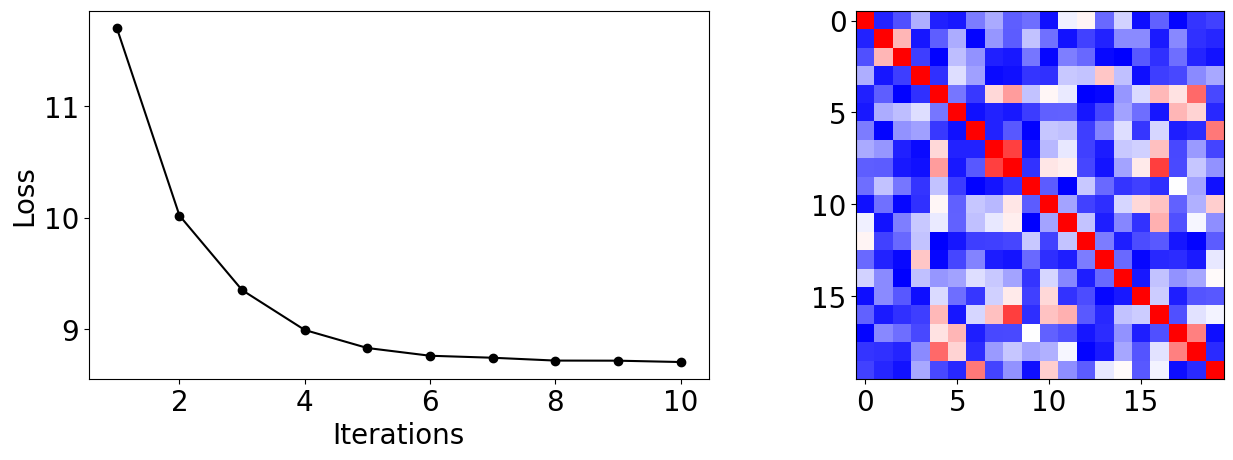

In [84]:
plot_data = cb_qkt.get_callback_data()  # callback data
K = optimized_kernel.evaluate(X_train[:num_data])  # kernel matrix evaluated on the training samples

plt.rcParams["font.size"] = 20
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
ax[0].plot([i + 1 for i in range(len(plot_data[0]))], np.array(plot_data[2]), c="k", marker="o")
ax[0].set_xlabel("Iterations")
ax[0].set_ylabel("Loss")
ax[1].imshow(K, cmap=matplotlib.colormaps["bwr"])
fig.tight_layout()
plt.show()

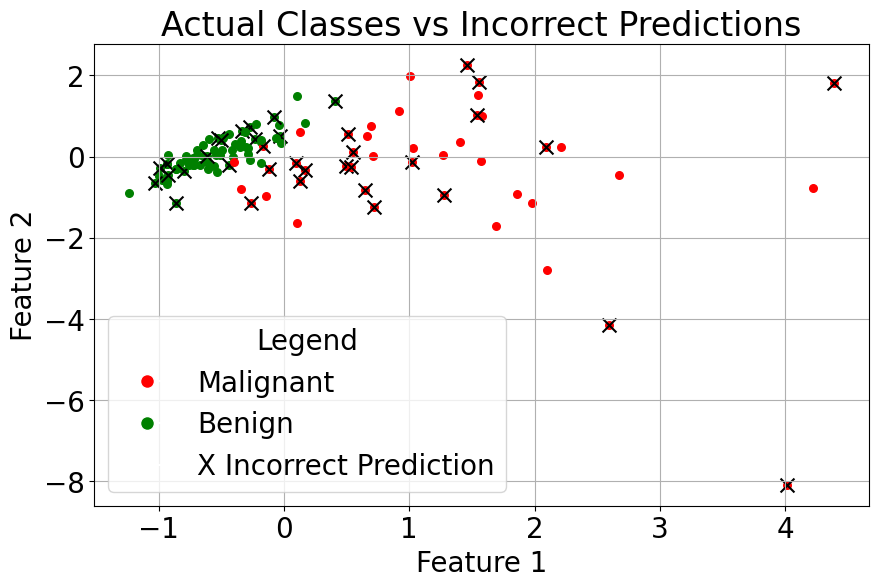

In [157]:
# Create a scatter plot, as it is a binary classification problem.
# For more classes we can use confusion matrix to plot heatmap

# Define legend labels for the different marker styles and colors
legend_labels = {
    'Malignant': {'color': 'red', 'marker': 'o'},
    'Benign': {'color': 'green', 'marker': 'o'},
    'X Incorrect Prediction': {'color': 'black', 'marker': 'x'},
}

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Iterate through each data point
for i in range(114):
    actual_label = y_test[i]
    predicted_label = labels_test[i]
    point = X_test[i]

    # Set marker color based on actual label
    if actual_label == 0: # Actual malignant
        legend_label = 'Malignant'  
        marker_color = 'red'  
    else: # Actual benign
        legend_label = 'Benign'  
        marker_color = 'green'  
    
    marker_style = 'o'
    marker_size = 30  # Smaller marker size for correct predictions

    # Create scatter plot with the specified marker properties
    plt.scatter(point[0], point[1], c=marker_color, marker=marker_style, s=marker_size)
    if actual_label != predicted_label:
        plt.scatter(point[0], point[1], c='black', marker='x', s=100) # Larger marker size for incorrect predictions

# Add a legend to the plot
legend_elements = [plt.Line2D([0], [0], marker=marker['marker'], color='w', label=label, markersize=10, markerfacecolor=marker['color']) for label, marker in legend_labels.items()]
plt.legend(handles=legend_elements, loc='lower left', title="Legend")

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Actual Classes vs Incorrect Predictions')
plt.grid(True)
plt.show()
# plt.clf()

- [https://qiskit.org/ecosystem/machine-learning/tutorials/03_quantum_kernel.html](https://qiskit.org/ecosystem/machine-learning/tutorials/03_quantum_kernel.html)

- [https://qiskit.org/ecosystem/machine-learning/tutorials/08_quantum_kernel_trainer.html](https://qiskit.org/ecosystem/machine-learning/tutorials/08_quantum_kernel_trainer.html)

- [ZZFeatureMap](https://qiskit.org/documentation/stubs/qiskit.circuit.library.ZZFeatureMap.html)

- [Optimizers](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.html)

- [N-Local Parameterized Circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#n-local-circuits)

- [Data Encoding Circuits](https://qiskit.org/documentation/apidoc/circuit_library.html#data-encoding-circuits)

- [QOSF Example 1](https://github.com/qosf/monthly-challenges/tree/main/challenge-2023.02-feb/PabloConteQOSFTask3)